In [63]:
import yfinance as yf
from scipy.signal import periodogram
from scipy.signal import lfilter
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from modules.Utils.utils import loadFromDB

# Q Spectrum

In [ ]:

# Collect Apple stock price data
data = loadFromDB("BTC",'1d')

# Preprocess the data
data.dropna(inplace=True)
data = data['Close']

# Estimate the Q-spectrum of the stock price data using the periodogram
f, Pxx_den = periodogram(data, fs=1/24/3600)

# Plot the Q-spectrum
plt.semilogy(f, Pxx_den)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.show()

# Hurst Exponent

- H < 0.5 — a mean-reverting (anti-persistent) series. The closer the value is to 0, the stronger the mean-reversion process is. In practice, it means that a high value is followed by a low value and vice-versa.
- H = 0.5 — a geometric random walk.
- H > 0.5 — a trending (persistent) series. The closer the value is to 1, the stronger the trend. In practice, it means that a high value is followed by a higher on

In [158]:
df = loadFromDB("BTC",'1d')#.loc["2021-05-01":]
print(df.shape)
df['Returns'] = df['Close'].pct_change()
df.dropna(inplace=True)
df.head()

History present -> Checking for refresh...
Last timestamp : 1677110400.0 = 23-02-2023
(1950, 7)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns
Date,,,,,,,,
2017-10-20 02:00:00,1.508458e+09,5137.927269,5698.297439,5998.207831,5137.927269,3.455172,19656.685812,0.109065
2017-10-21 02:00:00,1.508544e+09,5698.297439,5985.000000,6660.000000,5692.000000,0.638032,3826.886013,0.050314
2017-10-22 02:00:00,1.508630e+09,5985.000000,6500.000000,6660.000000,5692.000000,1.873153,11395.237645,0.086048
2017-10-23 02:00:00,1.508717e+09,6229.650000,6150.000000,6500.000000,5692.000000,2.809644,16958.340642,-0.053846
2017-10-24 02:00:00,1.508803e+09,6150.000000,5732.000000,6150.000000,5269.276017,5.359625,29775.583235,-0.067967


In [159]:
power=4
n=2**power

def get_hurst_exponent(time_series:pd.Series)->float:
    """Returns the Hurst Exponent of the time series"""
    
    time_series = time_series.values
    max_lag=20#len(time_series//2)
    
    lags = range(2, max_lag)
    
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

def get_hurst_exponent_dsod(time_series:pd.Series)->float:
    y = np.cumsum(np.diff(time_series, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)

 #min_chunksize=8, max_chunksize=200, num_chunksize=5
 
def get_hurst_exponent_dma(time_series:pd.Series)->float:
    max_chunksize = 200
    num_chunksize = 5
    min_chunksize = 8
    
    prices = time_series.values
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    
    return H

def get_hurst_exponent_rs(time_series:pd.Series)->float:
    x = time_series.values
    N = len(x)
    max_chunksize = 200
    num_chunksize = 5
    min_chunksize = 8
    
    
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    #out[0] = H
    return H


from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant

def calculate_rs(rows_array:pd.Series)->float:
    data = rows_array.values
    X = np.arange(2,power+1)
    Y = np.array([])
    for p in X:
        m=2**p
        s=2**(power-p)
        rs_array = np.array([])
        for i in np.arange(0,s):
            subsample=data[i*m:(i+1)*m]
            deviate = np.cumsum(subsample-np.average(subsample))
            diff= max(deviate)-min(deviate)
            stdev = np.std(subsample)
            rs_array  = np.append(rs_array,diff/stdev)
        Y = np.append(Y,np.log2(np.average(rs_array)))
    reg = OLS(Y,add_constant(X))
    res = reg.fit()
    return res.params[1]
   


In [160]:
df['Hurst_expo'] = df['Close'].rolling(n).apply(get_hurst_exponent)
df['Hurst_expo_dsod'] = df['Close'].rolling(n).apply(get_hurst_exponent_dsod)
#df['Hurst_expo_dma'] = df['Close'].rolling(100).apply(get_hurst_exponent_dma)
df['Hurst_expo_rs'] = df['Close'].rolling(n).apply(get_hurst_exponent_rs)
df['Hurst_expo_rs_2'] = df['Close'].rolling(n).apply(calculate_rs)

/home/baptiste/myworkdir/trading-sandbox/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2142/1995733889.py:101: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, c = np.linalg.lstsq(


In [156]:
df

,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Hurst_expo,Hurst_expo_dsod,Hurst_expo_rs,Hurst_expo_rs_2
Date,,,,,,,,,,,,
2017-10-20 02:00:00,1.508458e+09,5137.927269,5698.297439,5998.207831,5137.927269,3.455172,1.965669e+04,0.109065,NaN,NaN,NaN,NaN
2017-10-21 02:00:00,1.508544e+09,5698.297439,5985.000000,6660.000000,5692.000000,0.638032,3.826886e+03,0.050314,NaN,NaN,NaN,NaN
2017-10-22 02:00:00,1.508630e+09,5985.000000,6500.000000,6660.000000,5692.000000,1.873153,1.139524e+04,0.086048,NaN,NaN,NaN,NaN
2017-10-23 02:00:00,1.508717e+09,6229.650000,6150.000000,6500.000000,5692.000000,2.809644,1.695834e+04,-0.053846,NaN,NaN,NaN,NaN
2017-10-24 02:00:00,1.508803e+09,6150.000000,5732.000000,6150.000000,5269.276017,5.359625,2.977558e+04,-0.067967,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 01:00:00,1.676938e+09,24840.000000,24733.100000,25248.000000,24555.000000,2638.486188,6.572240e+07,-0.004300,NaN,0.096611,-6.235329e-17,1.036261
2023-02-21 01:00:00,1.676938e+09,24840.000000,24448.800000,25248.000000,24152.500000,5893.449652,1.455299e+08,-0.011495,NaN,0.055635,-1.086600e-16,1.050377
2023-02-22 01:00:00,1.677024e+09,24448.900000,23787.400000,24474.900000,23632.100000,3351.866265,8.061770e+07,-0.027052,NaN,0.137608,-1.599970e-16,1.062648


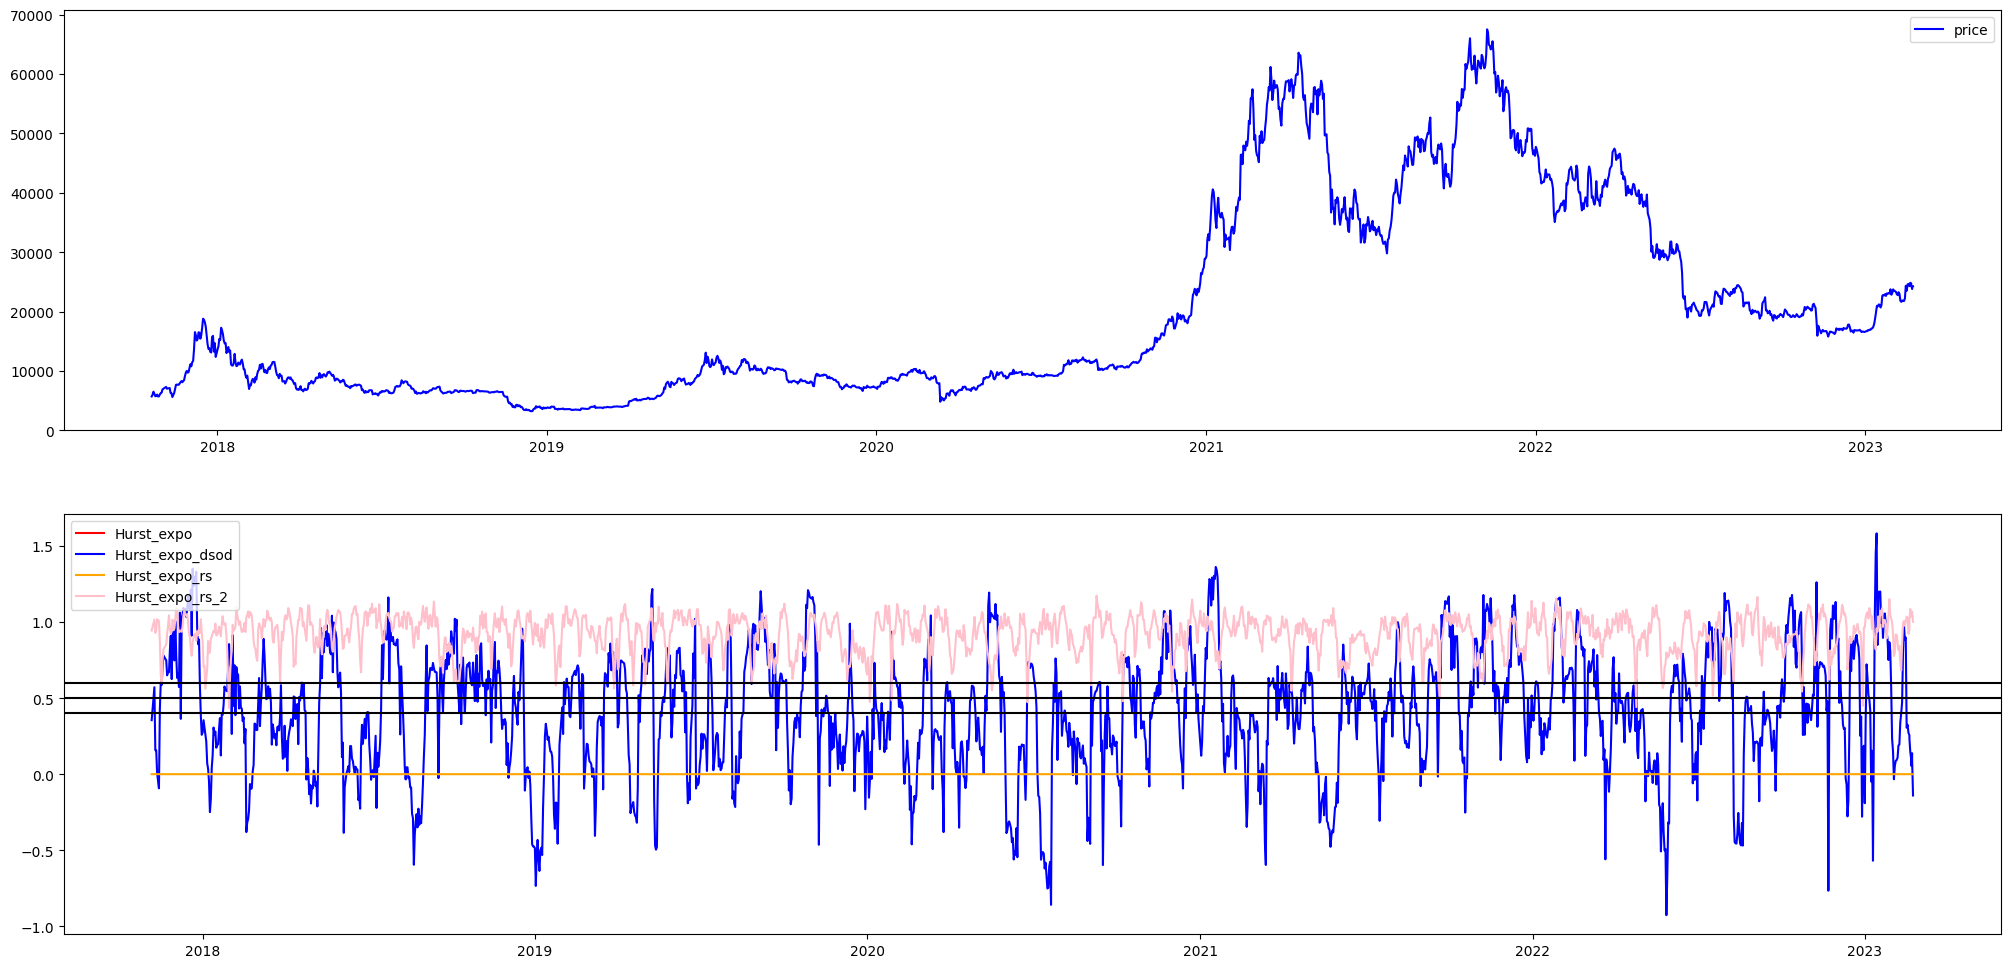

In [161]:
import matplotlib.pyplot as plt
#df.dropna(inplace=True)

# df = df[-400:]
fig, ax = plt.subplots(2,1,figsize=(25,12))
ax[0].plot(df.Close,color='blue',label="price")
ax[0].legend()

ax[1].plot(df.Hurst_expo,color='r',label="Hurst_expo")
ax[1].plot(df.Hurst_expo_dsod,color='b',label="Hurst_expo_dsod")
# ax[1].plot(df.Hurst_expo_dma,color='r',label="Hurst_expo_dma")
ax[1].plot(df.Hurst_expo_rs,color='orange',label="Hurst_expo_rs")
ax[1].plot(df.Hurst_expo_rs_2,color='pink',label="Hurst_expo_rs_2")
ax[1].axhline(y=0.5, color='black')
ax[1].axhline(y=0.6, color='black')
ax[1].axhline(y=0.4, color='black')
ax[1].legend(loc='upper left')

# ax[2].plot(theorical_trades.equity,color='r',label="equity")
# ax_l = ax[2].twinx()
# ax_l.scatter(theorical_trades.index, theorical_trades.nb_trade,color='b',label="Number of trade")
# ax_l.legend(loc='upper right')
# ax[2].legend(loc='upper left')

#MFDFA

In [ ]:
from MFDFA import MFDFA
from MFDFA import fgn
# where this second library is to generate fractional Gaussian noises

# integration time and time sampling
t_final = 2000
delta_t = 0.001

# Some drift theta and diffusion sigma parameters
theta = 0.3
sigma = 0.1

# The time array of the trajectory
time = np.arange(0, t_final, delta_t)

# The fractional Gaussian noise
H = 0.7
dB = (t_final ** H) * fgn(N = time.size, H = H)

# Initialise the array y
y = np.zeros([time.size])

# Integrate the process
for i in range(1, time.size):
    y[i] = y[i-1] - theta * y[i-1] * delta_t + sigma * dB[i]

In [ ]:
# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 2

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag, dfa = MFDFA(y, lag = lag, q = q, order = order)

In [ ]:
# To uncover the Hurst index, lets get some log-log plots
plt.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2')

# And now we need to fit the line to find the slope. Don't
# forget that since you are plotting in a double logarithmic
# scales, you need to fit the logs of the results
H_hat = np.polyfit(np.log(lag)[4:20],np.log(dfa[4:20]),1)[0]

# Now what you should obtain is: slope = H + 1
print('Estimated H = '+'{:.3f}'.format(H_hat[0]))